In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras.layers import BatchNormalization

In [2]:
parent_folder_path = "D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-deseases\IMG_CLASSES"

In [3]:
# Initialize lists for image paths and labels
image_paths = []
class_labels = []

# Initialize a dictionary for class label mappings
class_label_map = {}

# Loop through subfolders in the parent folder
for subfolder_name in os.listdir(parent_folder_path):
    # Extract class label from subfolder name
    class_label = int(subfolder_name.split(".")[0]) - 1
    
    # Loop through image files in the subfolder
    class_label_map[class_label] = subfolder_name.split(".")[1].split(" ")[1]
    
    # loop through each image file in the subfolder
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    for image_name in os.listdir(subfolder_path):
        # Get full path to the image file
        image_path = os.path.join(subfolder_path, image_name)
        
        # Append image path and class label to lists
        image_paths.append(image_path)
        class_labels.append(class_label)

# Create a DataFrame from image paths and class labels
data = {"image_path": image_paths, "class_label": class_labels}
df = pd.DataFrame(data)

# Print the class label map
print(class_label_map)

{0: 'Eczema', 9: 'Warts', 1: 'Melanoma', 2: 'Atopic', 3: 'Basal', 4: 'Melanocytic', 5: 'Benign', 6: 'Psoriasis', 7: 'Seborrheic', 8: 'Tinea'}


In [4]:
df

,image_path,class_label
0,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0
1,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0
2,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0
3,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0
4,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0
...,...,...
27148,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,8
27149,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,8
27150,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,8
27151,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,8


In [5]:
# Get the list of subdirectories in the dataset directory (each subdirectory corresponds to a class)
class_names = os.listdir(parent_folder_path)

# Loop over the subdirectories and count the number of files in each one
for class_name in class_names:
    class_dir = os.path.join(parent_folder_path, class_name)
    num_images = len(os.listdir(class_dir))
    print("Class {}: {} images".format(class_name, num_images))

Class 1. Eczema 1677: 1677 images
Class 10. Warts Molluscum and other Viral Infections - 2103: 2103 images
Class 2. Melanoma 15.75k: 3140 images
Class 3. Atopic Dermatitis - 1.25k: 1257 images
Class 4. Basal Cell Carcinoma (BCC) 3323: 3323 images
Class 5. Melanocytic Nevi (NV) - 7970: 7970 images
Class 6. Benign Keratosis-like Lesions (BKL) 2624: 2079 images
Class 7. Psoriasis pictures Lichen Planus and related diseases - 2k: 2055 images
Class 8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 1847 images
Class 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 1702 images


### EDA

<Axes: xlabel='class_label'>

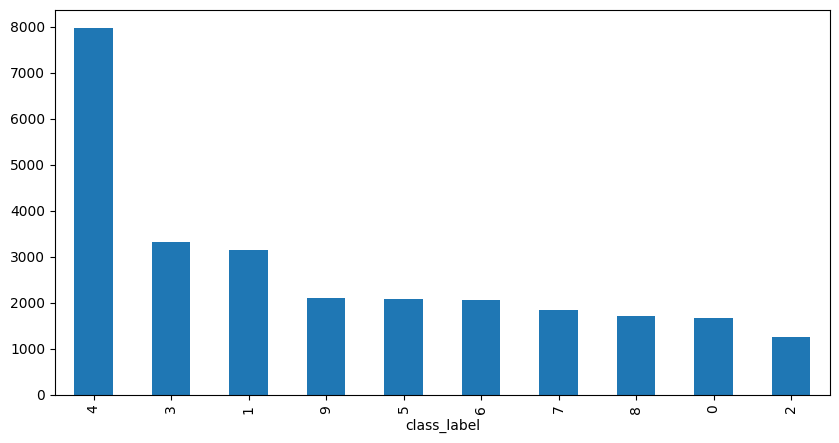

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_label'].value_counts().plot(kind='bar', ax=ax1)

In [7]:
max_images_per_class = 4000
df = df.groupby('class_label').head(max_images_per_class).sort_values(by='class_label').reset_index(drop=True)

<Axes: xlabel='class_label'>

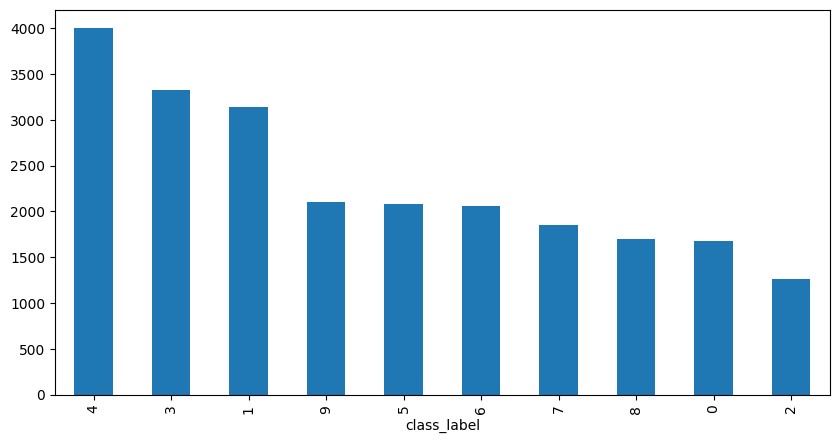

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_label'].value_counts().plot(kind='bar', ax=ax1)
# df['class_label_name'] = df['class_label'].map(class_label_map).value_counts().plot(kind='bar', ax=ax1)

### Convert Image to Array

In [9]:
import concurrent.futures

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[]


In [10]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

4

In [11]:
# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays
df

,image_path,class_label,image
0,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0,"[[[143, 135, 130], [149, 138, 134], [151, 144,..."
1,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0,"[[[23, 17, 5], [31, 27, 19], [34, 28, 23], [29..."
2,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0,"[[[33, 26, 21], [36, 30, 26], [30, 22, 16], [3..."
3,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0,"[[[9, 1, 0], [10, 2, 0], [9, 1, 0], [10, 2, 0]..."
4,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,0,"[[[8, 3, 0], [8, 3, 0], [8, 3, 0], [10, 3, 1],..."
...,...,...,...
23178,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,9,"[[[165, 136, 119], [164, 138, 122], [162, 136,..."
23179,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,9,"[[[189, 155, 120], [188, 154, 118], [195, 164,..."
23180,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,9,"[[[80, 68, 44], [81, 69, 45], [81, 68, 44], [8..."
23181,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,9,"[[[213, 173, 143], [210, 176, 149], [207, 177,..."


In [12]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    23183
Name: count, dtype: int64

In [13]:
from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [14]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'class_label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['class_label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['class_label'] == class_label, 'image'].values
    
    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)
        
        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)
            
            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = pd.concat([augmented_df, pd.DataFrame({'image_path': [None], 'class_label': [class_label], 'image': [augmented_image_array]})], ignore_index=True)
    
    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['class_label'] == class_label, ['image_path', 'class_label', 'image']]
    augmented_df = pd.concat([augmented_df, original_images_df], ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('class_label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

,image_path,class_label,image
0,None,8,"[[[187, 163, 197], [186, 164, 195], [182, 158,..."
1,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,4,"[[[16, 19, 20], [17, 19, 21], [11, 14, 16], [5..."
2,None,7,"[[[200, 171, 154], [200, 170, 153], [200, 170,..."
3,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,1,"[[[149, 139, 134], [156, 142, 134], [160, 147,..."
4,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,6,"[[[88, 70, 56], [85, 66, 58], [79, 62, 53], [7..."
...,...,...,...
39995,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,1,"[[[196, 148, 160], [196, 145, 152], [196, 141,..."
39996,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,2,"[[[177, 140, 111], [177, 140, 112], [176, 139,..."
39997,D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\skin-des...,9,"[[[176, 124, 77], [180, 125, 78], [187, 133, 9..."
39998,None,0,"[[[148, 111, 111], [148, 111, 111], [146, 109,..."


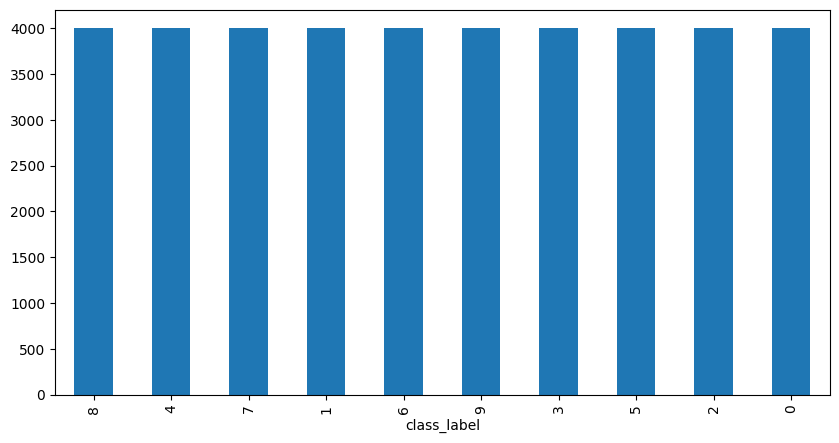

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['class_label'].value_counts().plot(kind='bar', ax=ax1)
df

In [16]:
features=df.drop(columns=['class_label','image_path'],axis=1)
target=df['class_label']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


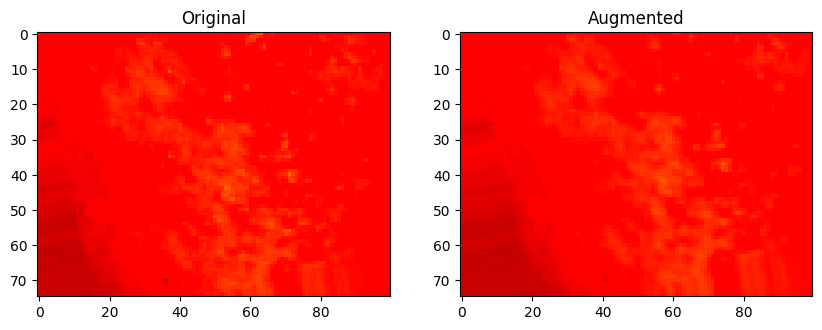

In [43]:
import random

# Get an image from the training data
img = x_train[random.randint(0, len(x_train))]

# Add an extra dimension to the image so that it has shape (1, height, width, channels)
img = np.expand_dims(img, axis=0)

# Create a generator to apply data augmentation to the image
aug_gen = datagen.flow(img, batch_size=1)

# Generate an augmented version of the image
aug_img = next(aug_gen)[0]

# Plot the original image and its augmented version
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(img[0])
axs[0].set_title('Original')
axs[1].imshow(aug_img)
axs[1].set_title('Augmented')
plt.show()

In [17]:
print(features)

                                                   image
0      [[[187, 163, 197], [186, 164, 195], [182, 158,...
1      [[[16, 19, 20], [17, 19, 21], [11, 14, 16], [5...
2      [[[200, 171, 154], [200, 170, 153], [200, 170,...
3      [[[149, 139, 134], [156, 142, 134], [160, 147,...
4      [[[88, 70, 56], [85, 66, 58], [79, 62, 53], [7...
...                                                  ...
39995  [[[196, 148, 160], [196, 145, 152], [196, 141,...
39996  [[[177, 140, 111], [177, 140, 112], [176, 139,...
39997  [[[176, 124, 77], [180, 125, 78], [187, 133, 9...
39998  [[[148, 111, 111], [148, 111, 111], [146, 109,...
39999  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

[40000 rows x 1 columns]


In [18]:
print(target)

0        8
1        4
2        7
3        1
4        6
        ..
39995    1
39996    2
39997    9
39998    0
39999    3
Name: class_label, Length: 40000, dtype: object


In [19]:
print(target.shape,features.shape)

(40000,) (40000, 1)


### Splitting Dataset

In [20]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

### Normalization

In [21]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [22]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o,num_classes = 10)
y_test = to_categorical(y_test_o,num_classes = 10)

In [23]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

In [24]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [25]:
# Define data augmentation parameters
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        shear_range=0.2, # Shear angle in counter-clockwise direction in degrees
)

# Prepare the data generators
train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = datagen.flow(x_validate, y_validate, batch_size=32)

### Build Model

In [26]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2

num_classes = 10
input_shape = (75,100,3)

# DenseNet121
model = Sequential()
model.add(DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 3, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 512)               3146240   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 10188874 (38.87 MB)
Trainable params: 10105226 (38.55 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

### Model Fitting

In [28]:
epochs = 50
batch_size=64
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/50
450/450 [==============================] - 8120s 18s/step - loss: 10.1307 - accuracy: 0.4718 - val_loss: 8.9754 - val_accuracy: 0.6006 - lr: 0.0010
Epoch 2/50
450/450 [==============================] - 8875s 20s/step - loss: 8.2387 - accuracy: 0.6320 - val_loss: 7.5211 - val_accuracy: 0.6622 - lr: 0.0010
Epoch 3/50
450/450 [==============================] - 8686s 19s/step - loss: 6.8440 - accuracy: 0.7138 - val_loss: 6.3621 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 4/50
450/450 [==============================] - 9366s 21s/step - loss: 5.6853 - accuracy: 0.7785 - val_loss: 5.4605 - val_accuracy: 0.7134 - lr: 0.0010
Epoch 5/50
450/450 [==============================] - 9146s 20s/step - loss: 4.7083 - accuracy: 0.8361 - val_loss: 4.6986 - val_accuracy: 0.7262 - lr: 0.0010
Epoch 6/50
450/450 [==============================] - 9102s 20s/step - loss: 3.8982 - accuracy: 0.8806 - val_loss: 4.0893 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 7/50
450/450 [==============================]

Epoch 48/50
450/450 [==============================] - 9311s 21s/step - loss: 0.0294 - accuracy: 0.9976 - val_loss: 0.8751 - val_accuracy: 0.8138 - lr: 3.1250e-05
Epoch 49/50
450/450 [==============================] - 9304s 21s/step - loss: 0.0286 - accuracy: 0.9980 - val_loss: 0.8748 - val_accuracy: 0.8125 - lr: 3.1250e-05
Epoch 50/50
450/450 [==============================] - ETA: 0s - loss: 0.0287 - accuracy: 0.9980 
Epoch 50: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
450/450 [==============================] - 10337s 23s/step - loss: 0.0287 - accuracy: 0.9980 - val_loss: 0.8731 - val_accuracy: 0.8125 - lr: 3.1250e-05


### Evaluation

250/250 [==============================] - 1074s 4s/step


<Axes: >

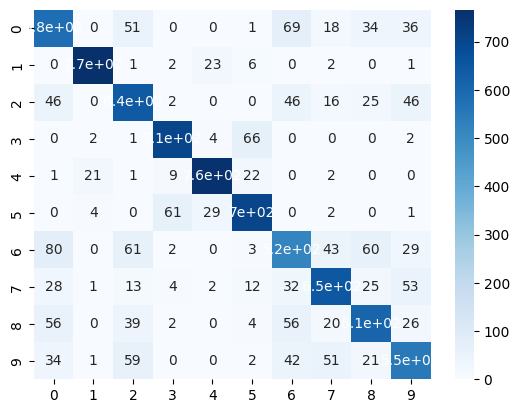

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

### Plotting

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.8107
Precision: 0.8104
Recall: 0.8103
F1-score: 0.8102
Kappa score: 0.7897


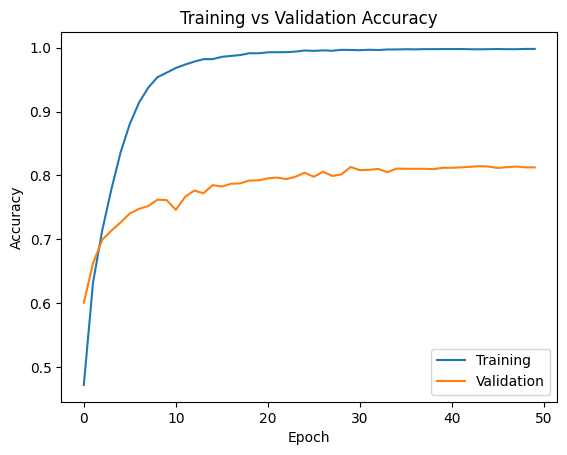

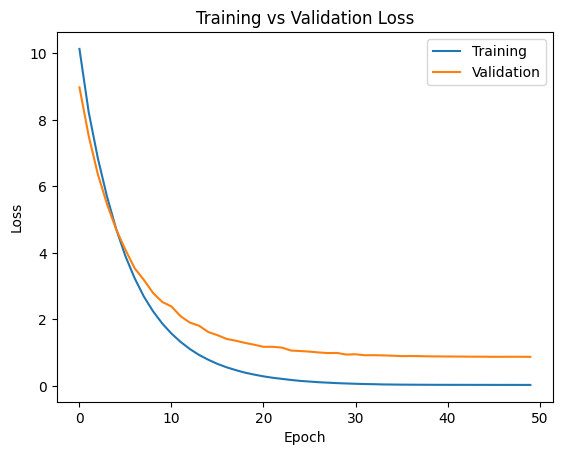

In [31]:
import matplotlib.pyplot as plt

# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

### Testing

In [33]:
from tensorflow.keras.preprocessing import image

# Label dictionary
label_dict = {
    0: 'Eczema', 9: 'Warts', 3: 'Basal', 6: 'Psoriasis', 4: 'Melanocytic',
    8: 'Tinea', 2: 'Atopic', 5: 'Benign', 7: 'Seborrheic', 1: 'Melanoma'
}

# Load and process image function
def load_and_preprocess_image(image_path, target_size):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Predict image function
def predict_image(image_path):
    input_shape = (75, 100)
    img_array = load_and_preprocess_image(image_path, target_size=input_shape)
    predictions = model.predict(img_array)

    for idx, prediction in enumerate(predictions[0]):
        print(f"{label_dict[idx]}: {prediction * 100:.2f}%")

    plt.imshow(image.load_img(image_path))
    plt.axis('off')
    plt.show()

1/1 [==============================] - 1s 785ms/step
Eczema: 0.00%
Melanoma: 0.00%
Atopic: 0.00%
Basal: 0.03%
Melanocytic: 0.00%
Benign: 0.00%
Psoriasis: 0.01%
Seborrheic: 0.01%
Tinea: 0.00%
Warts: 99.94%


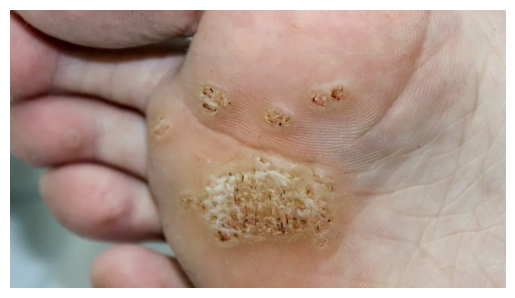

In [39]:
predict_image('D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\img-lainlain\Plantar-warts-body3.jpg')

1/1 [==============================] - 1s 922ms/step
Eczema: 0.00%
Melanoma: 0.02%
Atopic: 99.39%
Basal: 0.00%
Melanocytic: 0.00%
Benign: 0.00%
Psoriasis: 0.48%
Seborrheic: 0.00%
Tinea: 0.01%
Warts: 0.09%


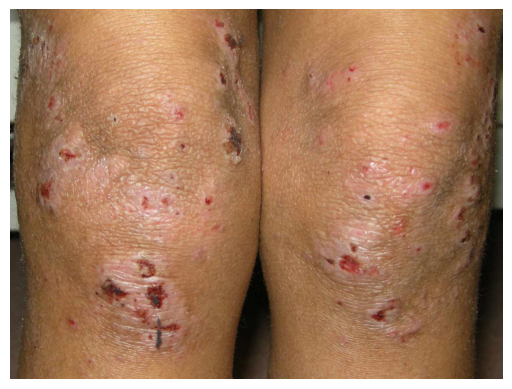

In [41]:
predict_image('D:\KULIAH\BANGKIT-ML\CAPSTONE-PRODUCT\img-lainlain\Health-156.atopic-dermatitis.jpg')

### Save to H5

In [44]:
model.save('model_capstone.h5')

C:\Program Files\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Convert to tflite

In [45]:
model = tf.keras.models.load_model('model_capstone.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_capstone.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\RIDHAN~1\AppData\Local\Temp\tmp6gqmsfpy\assets


INFO:tensorflow:Assets written to: C:\Users\RIDHAN~1\AppData\Local\Temp\tmp6gqmsfpy\assets
